<center><h1>Get Data on NHS Waiting Times</h1></center>

<h3>Get urls of all pages with the data</h3>

In [1]:
import requests, sys, webbrowser, bs4, os
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
from time import strptime
import matplotlib
import csv
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=20)

printOutput = False

os.makedirs('Bed_Data', exist_ok=True)

root_url = "https://www.england.nhs.uk/statistics/statistical-work-areas/bed-availability-and-occupancy/bed-data-overnight/"
res = requests.get(root_url)
soup = bs4.BeautifulSoup(res.content)

linkElems = soup.select("a")
page_names = []

for elem in linkElems:
    if "NHS organisations in England, Quarter" in elem.getText():
        page_names.append(elem.get('href'))
        
print("Total of {} pages found".format(len(page_names)))

Total of 40 pages found


<h2>Take data from xls files</h2>

In [2]:
attendence_months = []
over4hours_months = []
period_months = []

attendence_weeks = []
over4hours_weeks = []
period_weeks = []


# Make vectorised int function
vecint = np.vectorize(int)

# Open first data set to get all of the hospital names 
# AttendenceData = np.zeros(len())

# Gather data that we actually want to use
data = page_names
        
###########################################
### Get names and initiate data storage ###
##########################################

resp = requests.get(data[0])
# Store the data in a temporary file
tempfile = open('tempfile.xls', 'wb')
tempfile.write(resp.content)
tempfile.close()
sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=14, usecols="A,B,C,D,E,F,G,H,I,J,K,L,M,N")

# List of names from the first sheet
firstNames = sheet['Org Name'].values        

BedsAvail = np.zeros((len(firstNames), len(data)),dtype=object) 
BedsAvail[:,:] = '-'
OccBeds = np.zeros((len(firstNames), len(data)),dtype=object) 
OccBeds[:,:] = '-'
    
for i, name in enumerate(data):  
    #print(i, name)
    
    # Get the data location
    resp = requests.get(name)

    # Store the data in a temporary file
    tempfile = open('tempfile.xls', 'wb')
    tempfile.write(resp.content)
    tempfile.close()

    # Get all of the data from row 16 with columns A to N
    # I don't think this is how try is supposed to be used but it works
    if not 'XLS-406K' in name:
        sheet_avail = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=14, usecols="F,G,H,I,J,K")
        sheet_occ = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=14, usecols="F,N,M,O,P,Q")
    else:
        sheet_avail = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=5, usecols="E,F,G,H,I")
        sheet_occ = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=5, usecols="E,L,M,N,O,P")
        
#     # calling head() method   
#     # storing in new variable  
#     data_top = sheet_occ.head()  

#     # display  
#     print(data_top)  
        
    #print(sheet)
    names = sheet_avail['Org Name'].values
    totalbeds = sheet_avail['Total '].values
    occbeds = sheet_occ['Total .1'].values
    
    for j, fname in enumerate(firstNames):
        if sum(names==fname) == 1:
            # Save attendance data
            beds = totalbeds[names==fname]
            assert len(beds) == 1
            BedsAvail[:,i][firstNames==fname] = beds
            
            # Save waiting data
            occ_beds = occbeds[names==fname]
            assert len(occ_beds) == 1
            OccBeds[:,i][firstNames==fname] = occ_beds
    
    print(i, end = ' ')

#     if printOutput == False:
#         print("{} complete of {}...".format(i+1,len(data)),end = "\r")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

<h2> Check Plot</h2>

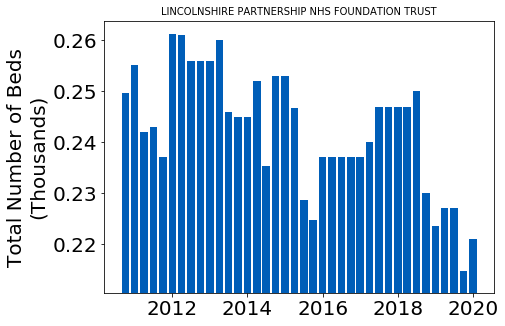

-28.79431438127088
214


In [3]:
fig, ax1 = plt.subplots(figsize = (7,5))
time = np.arange(2010.25, 2020.25, 0.25)[::-1]

hospital = 100

allBeds = BedsAvail[hospital,:][BedsAvail[hospital,:]!='-']
ax1.set_title(firstNames[hospital],size = 10)
ax1.bar(time[BedsAvail[hospital,:]!='-'], allBeds*1e-3, width = 0.2,
        align='center', alpha=1, color="#005EB8")
#plt.plot(time, allBeds,'r.',lw=2)
ax1.set_ylim(0.98*min(allBeds)*1e-3, 1.01*max(allBeds)*1e-3)
ax1.set_ylabel("Total Number of Beds\n(Thousands)")
plt.show()

print(allBeds[0]-allBeds[-1])
print(int(allBeds[1]))

In [4]:
better = 0
worse = 0
same = 0
change = np.zeros(len(firstNames[2:]))
for i, name in enumerate(firstNames[2:]):
    Beds = BedsAvail[firstNames == name]
    Beds = Beds[Beds!='-']
    
    change[i] = Beds[0]-Beds[-1]
    if change[i]>Beds[-1]*0.05:
        better += 1
    elif change[i]<-Beds[-1]*0.05:
        worse += 1
    else:
        same += 1

#plt.plot(time[BedfordBedsAvail != '-'], remaining,lw=2)

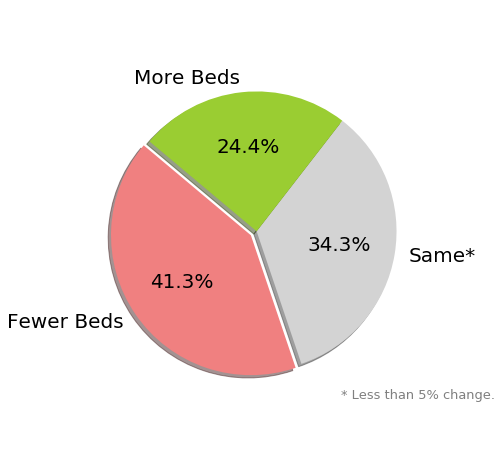

In [39]:
# Data to plot
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=20)

plt.figure(figsize = (7,7))
labels = 'Fewer Beds', 'Same*', 'More Beds'
sizes = [worse, same, better]
colors = ['lightcoral', 'lightgray', 'yellowgreen']
explode = (0.05, 0.0, 0.0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.tight_layout()
plt.annotate("* Less than 5% change.", (0.6, -1.2), size = 13, color = "gray")
plt.savefig("BedsPieChart.png")
plt.show()

#Bahnschrift Light

<h3>Tidy up the data</h3>

In [6]:
# Take out 'nan' value
OutNames = np.delete(firstNames,1)

# Make all names lower case
for i, name in enumerate(OutNames):
    OutNames[i] = name.lower()

# Turn values to integers
BedsOut = np.delete(BedsAvail, 1, axis = 0)
for i in range(len(OutNames)):
    if i != 1:
        for j, val in enumerate(BedsOut[i]):
            if val != '-':
                BedsOut[i][j] = int(val)

In [7]:
np.save("NHSbeds.npy", [OutNames, time, BedsOut])

In [8]:
firstNames, time, BedsAvail = np.load("NHSbeds.npy", allow_pickle=True)

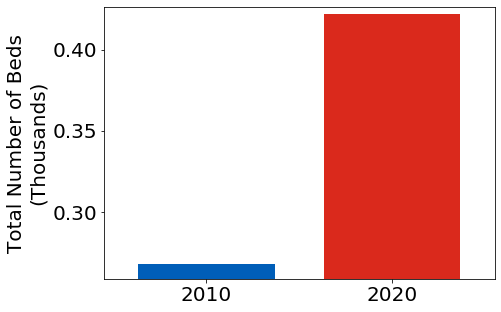

In [9]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=20)

fig, ax1 = plt.subplots(figsize = (7,5))
time = np.arange(2010.25, 2020, 0.25)[::-1]

hospital = 100

allBeds = BedsAvail[hospital,:][BedsAvail[hospital,:]!='-']

ax1.bar([time[-1], time[0]], [allBeds[-1]*1e-3, allBeds[0]*1e-3], 
        width = 7, alpha=1,tick_label = [2010, 2020], color = ['#005EB8', '#DA291C'])
ax1.set_xlim(2005, 2025)
ax1.set_ylim(0.98*min(allBeds)*1e-3, 1.01*max(allBeds)*1e-3)
ax1.set_ylabel("Total Number of Beds\n(Thousands)")
plt.show()


In [10]:
allBeds[-1] -allBeds[0]

-154

In [11]:
time

array([2019.75, 2019.5 , 2019.25, 2019.  , 2018.75, 2018.5 , 2018.25,
       2018.  , 2017.75, 2017.5 , 2017.25, 2017.  , 2016.75, 2016.5 ,
       2016.25, 2016.  , 2015.75, 2015.5 , 2015.25, 2015.  , 2014.75,
       2014.5 , 2014.25, 2014.  , 2013.75, 2013.5 , 2013.25, 2013.  ,
       2012.75, 2012.5 , 2012.25, 2012.  , 2011.75, 2011.5 , 2011.25,
       2011.  , 2010.75, 2010.5 , 2010.25])